In [103]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [104]:
input_size = 64
batch = 128
hidden_size = 128
num_layers = 1
num_epochs = 1000
learning_rate = 0.01

In [105]:
def generate():
    x = np.random.randint(3, size=(batch,1,input_size)) - 1
    y = np.zeros((batch,1))
    for i in range(batch):
        unique, counts = np.unique(x[i,:,:], return_counts=True)
        try:
            y[i,0] = dict(zip(unique, counts))[1]%2
        except:
            y[i,0] = 0
    x = Variable(torch.from_numpy(x).float())
    y = Variable(torch.from_numpy(y).float())
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    return x, y

In [106]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Forward propagate RNN
        h0= self.init_hidden_state()
        out, h0 = self.rnn(x, h0)
        out = out[:,-1,:]
        out = self.fc(out)
        out = F.sigmoid(out)
        return out
    
    def init_hidden_state(self):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size).cuda()) 
        else:
            h0 = Variable(torch.zeros(self.num_layers, batch, self.hidden_size)) 
        return h0

rnn = RNN(input_size, hidden_size, num_layers)
if torch.cuda.is_available():
    rnn.cuda()

In [107]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [108]:
def accuracy(y,out):
    y = y.data.numpy()
    out = out.data.numpy()
    out = np.round(out)
    return 1 - (sum(abs(y-out))/(batch))

In [109]:
losses = np.zeros(num_epochs)
acc = np.zeros(num_epochs)
for i in range(num_epochs):
    rnn.zero_grad()
    x,y = generate()
    out = rnn(x)
    loss = criterion(out,y)
    losses[i] = loss.data[0]
    acc[i] = accuracy(out,y)
    loss.backward()
    optimizer.step()
    if (i+1)%(num_epochs//20) == 0:
        print('Step '+ str(i+1) + '/' +str(num_epochs)+' done. Loss = ' + str(losses[i])+ '. Accuracy = ' + str(acc[i]))

Step 50/1000 done. Loss = 0.688254058361. Accuracy = 0.503508865833
Step 100/1000 done. Loss = 0.695935130119. Accuracy = 0.499405622482
Step 150/1000 done. Loss = 0.692672848701. Accuracy = 0.501103162766
Step 200/1000 done. Loss = 0.694156885147. Accuracy = 0.503126680851
Step 250/1000 done. Loss = 0.676254570484. Accuracy = 0.511129140854
Step 300/1000 done. Loss = 0.657199382782. Accuracy = 0.527724981308
Step 350/1000 done. Loss = 0.609301269054. Accuracy = 0.563777446747
Step 400/1000 done. Loss = 0.474330872297. Accuracy = 0.646049976349
Step 450/1000 done. Loss = 0.306890279055. Accuracy = 0.756637275219
Step 500/1000 done. Loss = 0.280543297529. Accuracy = 0.792069196701
Step 550/1000 done. Loss = 0.159859284759. Accuracy = 0.862184524536
Step 600/1000 done. Loss = 0.10462410748. Accuracy = 0.903721988201
Step 650/1000 done. Loss = 0.0631424114108. Accuracy = 0.940008044243
Step 700/1000 done. Loss = 0.0546521693468. Accuracy = 0.947783648968
Step 750/1000 done. Loss = 0.03793

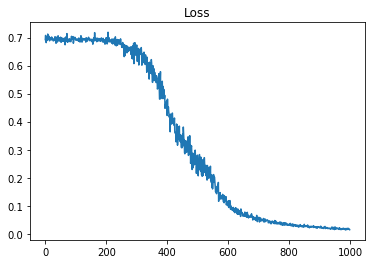

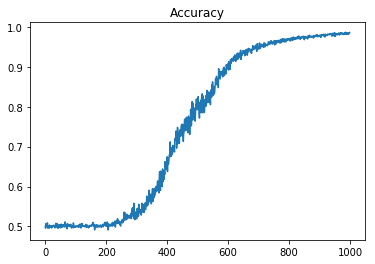

In [110]:
%matplotlib inline
plt.plot(losses)
plt.title('Loss')
plt.figure()
plt.plot(acc)
plt.title('Accuracy')